## Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.timeseries import LombScargle
import os
os.environ['JAX_PLATFORM_NAME'] = 'cpu' 
from scipy.stats import norm, linregress
#from gpyrn import covfunc, meanfunc, meanfield
import exoplanet as xo
from scipy.optimize import minimize
from scipy.stats import norm
import csv
from scipy import stats
from multiprocessing import Pool
import emcee
import corner
from loguniform import LogUniform, ModifiedLogUniform
import sys
sys.path.append(os.path.abspath("/home/paul/Bureau/IRAP/TediGP"))
import process, kernels, means
from scipy import signal
from tqdm import tqdm
import pandas as pd
from scipy.stats.stats import pearsonr 

np.random.seed(110**2)

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Load 2 first componant

In [2]:
eigen2vectors = np.load('/home/paul/Bureau/IRAP/dLWPCA/out/TablesAU_MIC/2firstcomponent.npy', allow_pickle=True) #### PATH TO CHANGE ####
times = np.load('/home/paul/Bureau/IRAP/dLWPCA/out/TablesAU_MIC/readyforwPCA_epoc.npy')                          #### PATH TO CHANGE ####

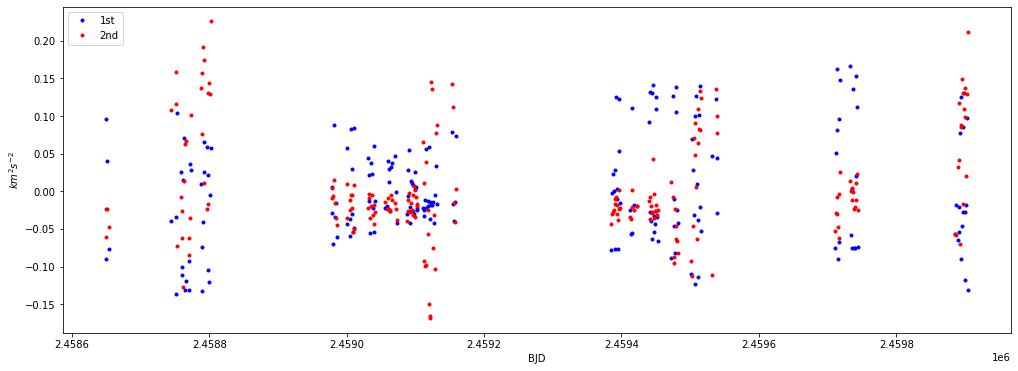

In [3]:
plt.figure(figsize=(17, 6))
plt.plot(times, eigen2vectors[0], 'b.', label='1st')
plt.plot(times, eigen2vectors[1], 'r.', label='2nd')
plt.xlabel('BJD')
plt.ylabel('$km^2 s^{-2}$')
plt.legend()
#plt.plot(times[:-1], eigen2vectors[3], 'r.')

plt.show()

## Periodograms
### 1st component

Peak frequency = 
4.872134347020897


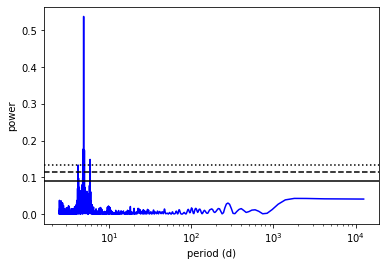

In [4]:
frequency, power = LombScargle(times, eigen2vectors[0]).autopower()
plt.figure(2)
plt.plot(1/frequency, power, 'b')
plt.xlabel("period (d)")
plt.ylabel("power")
plt.xscale('log')


peak_freq = 1 / frequency[np.argmax(power)]
print('Peak frequency = ')
print(peak_freq)

ls = LombScargle(times, eigen2vectors[0])

fap = ls.false_alarm_level(0.1)
plt.axhline(fap, linestyle='-', color='k')

fap = ls.false_alarm_level(0.01)
plt.axhline(fap, linestyle='--', color='k')

fap = ls.false_alarm_level(0.001)
plt.axhline(fap, linestyle=':', color='k')

plt.show()

Very strong Peak at $P_{rot}$

### 2nd component

Peak frequency = 
358.7282917792244


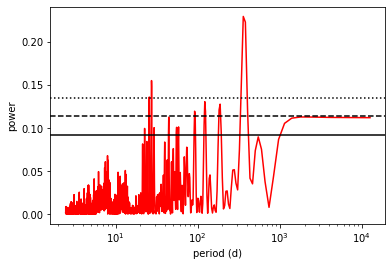

In [5]:
frequency, power = LombScargle(times, eigen2vectors[1]).autopower()
plt.figure(2)
plt.plot(1/frequency, power, 'r')
plt.xlabel("period (d)")
plt.ylabel("power")
plt.xscale('log')


peak_freq = 1 / frequency[np.argmax(power)]
print('Peak frequency = ')
print(peak_freq)

ls = LombScargle(times, eigen2vectors[1])

fap = ls.false_alarm_level(0.1)
plt.axhline(fap, linestyle='-', color='k')

fap = ls.false_alarm_level(0.01)
plt.axhline(fap, linestyle='--', color='k')

fap = ls.false_alarm_level(0.001)
plt.axhline(fap, linestyle=':', color='k')

plt.show()

## First component GP

Just to recall the GP uses a Quasi-Periodic covariance function that is build that way:


$K_{ij} = \eta_1^2 \, \exp \left[- \frac{(t_i - t_j)^2}{2 \eta_2^2} - \frac{2 }{\eta_4^2} \sin^2 \left( \frac{\pi (t_i - t_j)}{\eta_3} \right) \right] + Jitter$ 

In [6]:
print(2*(np.max(eigen2vectors[0])- np.min(eigen2vectors[0])))
print(np.std(eigen2vectors[0]))
print(10*(np.max(times)-np.min(times)))


0.6068144775809226
0.07001222336212883
12555.490212272853


For the Prior distribution, I use : 

$\eta_1 : \mathcal{MLU}\left( y_\sigma , 2 \times y_{ptp} \right)$

$\eta_2 : \mathcal{LU}\left( 1 , 10 \times t_{total} \right)$

$\eta_3 : \mathcal{N}\left( P , 0.1 \right)$

$\eta_4 : \mathcal{LU}\left( 0.1, 5 \right)$

$Jitter : \mathcal{MLU}\left( y_\sigma , 2 \times y_{ptp} \right)$

In [34]:
#Priors
n_eta1 = ModifiedLogUniform(0.07, 0.6)
n_eta2 = stats.loguniform(1, 565)
n_eta3 = stats.norm(loc=4.865, scale=0.1)
n_eta4 = stats.loguniform(0.1, 5)
jitter = ModifiedLogUniform(0.07, 0.6)

In [35]:
def priors():
    return np.array([n_eta1.rvs(),n_eta2.rvs(), n_eta3.rvs(), n_eta4.rvs(), jitter.rvs()])

In [36]:
def logPosterior(HyperParam):
    n1,n2,n3,n4, j = HyperParam
    
    logprior = n_eta1.logpdf(n1)
    logprior += n_eta2.logpdf(n2)
    logprior += n_eta3.logpdf(n3)
    logprior += n_eta4.logpdf(n4)
    logprior += jitter.logpdf(j)
    
    kernel = kernels.QuasiPeriodic(n1,n2,n3,n4) + kernels.WhiteNoise(j)
    mean = means.Constant(np.mean(eigen2vectors[0]))
    gpOBJ = process.GP(kernel,mean,times,eigen2vectors[0], yerr = 1e-12 * np.identity(times.size))
    
    logposterior = gpOBJ.log_likelihood() + logprior
    return logposterior

In [37]:
ndim = priors().size 
nwalkers = 2*ndim

In [38]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, logPosterior)
p0=[priors() for i in range(nwalkers)]
sampler.run_mcmc(p0, 10000, progress=True)

100%|██████████| 10000/10000 [05:28<00:00, 30.44it/s]


State([[7.29595342e-02 1.48848528e+02 4.86067362e+00 9.05522820e-01
  6.83195923e-03]
 [7.85718625e-02 1.61050783e+02 4.86136540e+00 9.93006332e-01
  8.08177732e-03]
 [6.81155953e-02 1.47510896e+02 4.86004396e+00 8.14301062e-01
  7.96221207e-03]
 [7.44420247e-02 1.35814817e+02 4.86179328e+00 8.56642923e-01
  7.37416584e-03]
 [6.86557505e-02 1.63124071e+02 4.86513855e+00 8.90125483e-01
  7.82943121e-03]
 [9.19806872e-02 1.43902240e+02 4.86045949e+00 1.08410311e+00
  7.62876565e-03]
 [6.74302877e-02 1.58759078e+02 4.86232218e+00 8.72361289e-01
  7.77812180e-03]
 [7.35086142e-02 1.35376055e+02 4.85966546e+00 9.48757723e-01
  7.80982781e-03]
 [7.72254395e-02 1.66557965e+02 4.86256096e+00 8.82046367e-01
  7.68218510e-03]
 [8.00597657e-02 1.48894054e+02 4.86245907e+00 1.01882431e+00
  7.59512550e-03]], log_prob=[559.12400898 559.5790905  560.01699658 559.55266784 559.37475116
 557.39559676 561.02379046 559.18092311 560.53497398 559.65244571], blobs=None, random_state=('MT19937', array([16756

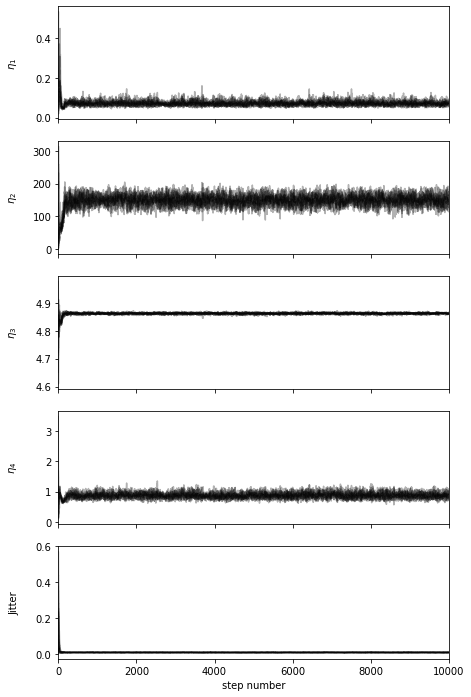

In [39]:
#chains plot
fig, axes = plt.subplots(5, figsize=(7, 12), sharex=True)
samples = sampler.get_chain()
labels = ["$\eta_1$", "$\eta_2$", "$\eta_3$", "$\eta_4$", "Jitter"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number");
plt.show()

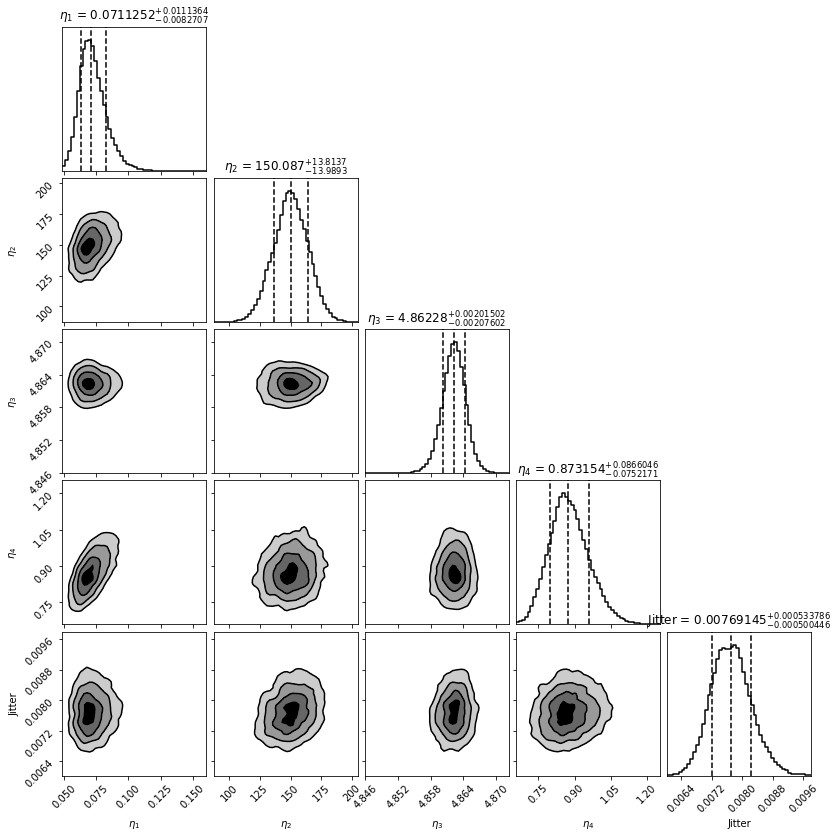

In [40]:
#corner plot
flat_samples = sampler.get_chain(discard=500, thin=15, flat=True)
fig = corner.corner(flat_samples,labels=labels, color="k", bins = 50,
                    quantiles=[0.16, 0.5, 0.84], smooth=True, smooth1d=True, 
                    show_titles=True, plot_density=True, plot_contours=True,
                    fill_contours=True, plot_datapoints=False, title_fmt='g')
plt.show()

$\eta_2$ and $\eta_3$ compatible with $<B>$ GP results from Donati et al. (2023, submitted)

$\eta_4$ compatible with $B_l$ GP results from Donati et al. (2023, submitted)

In [41]:
def Display(HyperParam, tplot):
    n1,n2,n3,n4, j = HyperParam
    
    kernel = kernels.QuasiPeriodic(n1,n2,n3,n4) + kernels.WhiteNoise(j)
    mean = means.Constant(np.mean(eigen2vectors[0]))
    gpOBJ = process.GP(kernel,mean,times,eigen2vectors[0],yerr = 1e-12 * np.identity(times.size))
    
    y_mean, y_std, time = gpOBJ.prediction(kernel,mean,tplot)
    return y_mean

In [42]:
tplot = np.linspace(2.4585e6, 2.46e6, 2000)

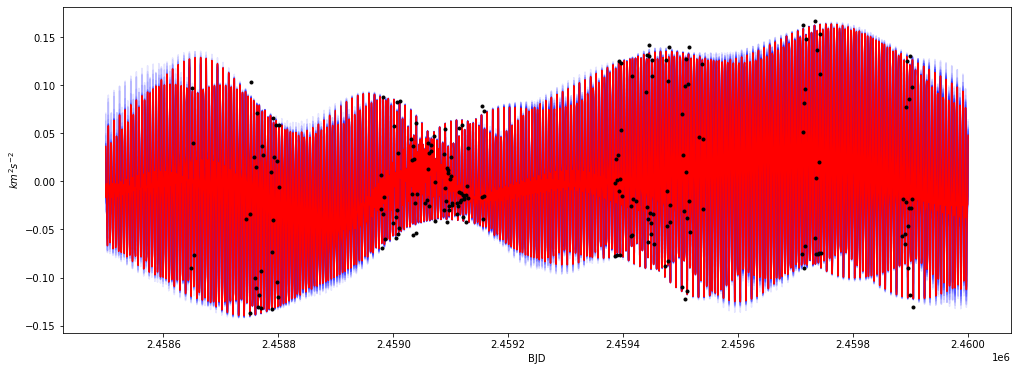

In [43]:
plt.figure(figsize=(17, 6))

for s in range(25):
    plt.plot(tplot, Display(flat_samples[s,:], tplot), 'b', alpha=0.1)
Hfit = np.median(sampler.flatchain, axis=0)
GPca = Display(Hfit, tplot)
plt.plot(tplot, GPca, 'r')
plt.plot(times, eigen2vectors[0],'k.')
plt.xlabel('BJD')
plt.ylabel('$km^2 s^{-2}$')
plt.show()

100%|██████████| 15/15 [00:02<00:00,  6.46it/s]


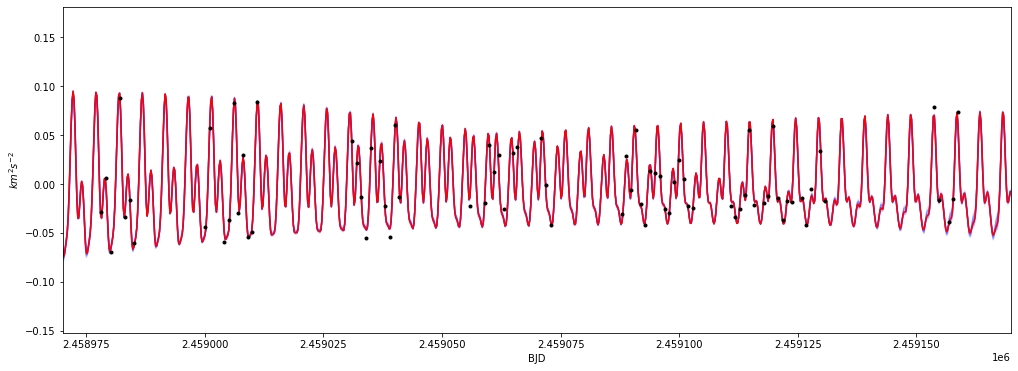

In [44]:
plt.figure(figsize=(17, 6))
tplot2 = np.linspace(-30+2459000, 170+2459000, 1000)

for s in tqdm(range(15)):
    plt.plot(tplot2, Display(flat_samples[s,:], tplot2), 'b', alpha=0.1)
Hfit = np.median(sampler.flatchain, axis=0)
plt.plot(tplot2, Display(Hfit, tplot2), 'r')
plt.plot(times, eigen2vectors[0],'k.')
plt.xlim([-30+2459000, 170+2459000])
plt.xlabel('BJD')
plt.ylabel('$km^2 s^{-2}$')
plt.show()

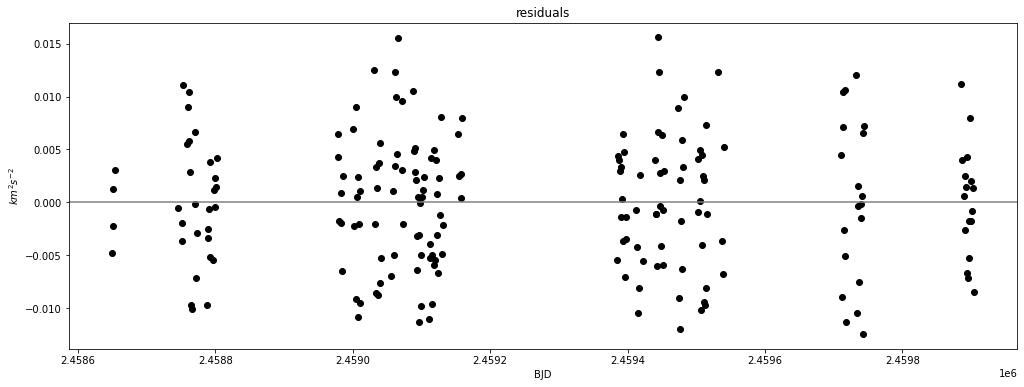

In [45]:
y_sample = Display(Hfit, times)

residuals = eigen2vectors[0] - y_sample
plt.figure(figsize=(17, 6))
plt.plot(times, residuals, 'ok')
plt.axhline(y=0, c='grey')
plt.annotate( "std :  " + str(np.std(residuals)), (2.4587*1e6, -0.015) )
plt.title('residuals')
plt.xlabel('BJD')
plt.ylabel('$km^2 s^{-2}$')
plt.show()

# Compares with Donati et al. (submitted)
## Load Data

## Magnetic Field B

In [46]:
B_table = np.loadtxt('/media/paul/One Touch2/SPIRou_Data/AU_MIC/B.txt')


times_pca = times 
times_B = B_table[:,0] + 2459000
B = B_table[:,1]
dB = B_table[:,2]

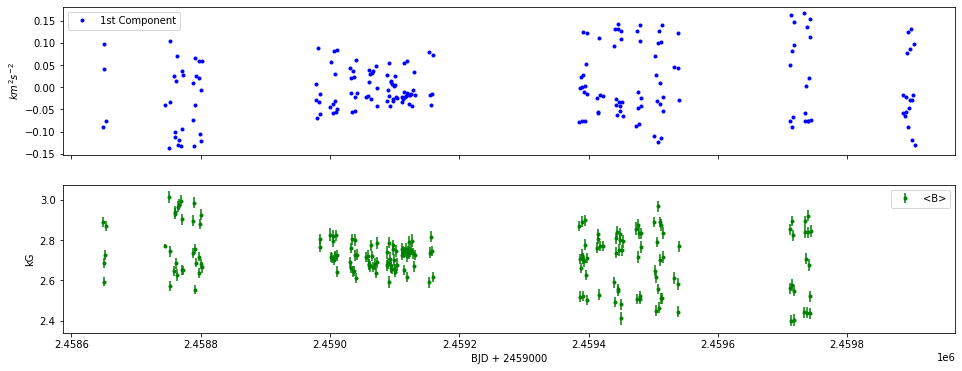

In [47]:
plt.figure(figsize=(16, 6))
ax1 = plt.subplot(211)
plt.plot(times_pca, eigen2vectors[0], 'b.', label='1st Component')
plt.ylabel('$km^2 s^{-2}$')
plt.legend()
plt.tick_params('x', labelbottom=False)


# share x and y
ax3 = plt.subplot(212, sharex=ax1)
plt.errorbar(times_B, B, yerr=dB, fmt='.g', label='<B>')
plt.xlabel('BJD + 2459000')
plt.ylabel('kG')
plt.legend()
plt.show()


Peak frequency = 
4.872610970181846


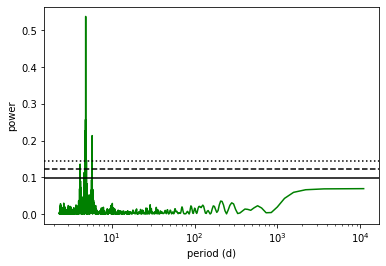

In [48]:
frequency, power = LombScargle(times_B, B).autopower()
plt.figure(2)
plt.plot(1/frequency, power, 'g')
plt.xlabel("period (d)")
plt.ylabel("power")
plt.xscale('log')


peak_freq = 1 / frequency[np.argmax(power)]
print('Peak frequency = ')
print(peak_freq)

ls = LombScargle(times_B, B)

fap = ls.false_alarm_level(0.1)
plt.axhline(fap, linestyle='-', color='k')

fap = ls.false_alarm_level(0.01)
plt.axhline(fap, linestyle='--', color='k')

fap = ls.false_alarm_level(0.001)
plt.axhline(fap, linestyle=':', color='k')

plt.show()

###  B GP

In [49]:
print(2*(np.max(B)- np.min(B)))
print(np.std(B))
print(10*(np.max(times_B)-np.min(times_B)))

1.2224000000000004
0.12771711650555842
10948.756849998608


In [50]:
#Priors
n_eta1 = ModifiedLogUniform(0.12, 1.2)
n_eta2 = stats.loguniform(1, 11000)
n_eta3 = stats.norm(loc=4.865, scale=0.1)
n_eta4 = stats.loguniform(0.1, 5)
jitter = ModifiedLogUniform(0.12, 1.2)

In [51]:
def priors():
    return np.array([n_eta1.rvs(),n_eta2.rvs(), n_eta3.rvs(), n_eta4.rvs(), jitter.rvs()])

def logPosterior(HyperParam):
    n1,n2,n3,n4, j = HyperParam
    
    logprior = n_eta1.logpdf(n1)
    logprior += n_eta2.logpdf(n2)
    logprior += n_eta3.logpdf(n3)
    logprior += n_eta4.logpdf(n4)
    logprior += jitter.logpdf(j)
    
    kernel = kernels.QuasiPeriodic(n1,n2,n3,n4) + kernels.WhiteNoise(j)
    mean = means.Constant(np.mean(B))
    gpOBJ = process.GP(kernel,mean,times_B,B, yerr = dB)
    
    logposterior = gpOBJ.log_likelihood() + logprior
    return logposterior

In [53]:
ndim = priors().size 
nwalkers = 2*ndim

sampler = emcee.EnsembleSampler(nwalkers, ndim, logPosterior)
p0=[priors() for i in range(nwalkers)]
sampler.run_mcmc(p0, 10000, progress=True)

100%|██████████| 10000/10000 [05:15<00:00, 31.73it/s]


State([[1.68989407e-01 1.58650955e+02 4.86461746e+00 1.52474658e+00
  8.32773205e-03]
 [1.97294275e-01 1.57268792e+02 4.85261786e+00 1.41110026e+00
  9.37684411e-03]
 [1.28169496e-01 1.75263653e+02 4.86318385e+00 1.21918649e+00
  5.27487904e-03]
 [1.49098514e-01 1.33169261e+02 4.87052696e+00 1.38279803e+00
  1.58079080e-04]
 [1.48821429e-01 1.29319209e+02 4.85755441e+00 1.30485590e+00
  6.74581218e-03]
 [2.95023451e-01 1.87379732e+02 4.86566028e+00 1.70018538e+00
  1.10607982e-02]
 [1.40220759e-01 1.54652430e+02 4.85609996e+00 1.35592580e+00
  1.12036708e-02]
 [1.47625369e-01 1.44691912e+02 4.86217195e+00 1.24978324e+00
  2.85077273e-03]
 [1.48509959e-01 1.59141529e+02 4.85545358e+00 1.47285517e+00
  1.10808072e-02]
 [1.66072933e-01 1.60349357e+02 4.85247661e+00 1.30317588e+00
  2.21037078e-03]], log_prob=[327.99933237 325.76359193 327.90496167 325.7144504  328.36428415
 322.65403981 327.76081244 329.26052516 327.2244041  326.96114351], blobs=None, random_state=('MT19937', array([28250

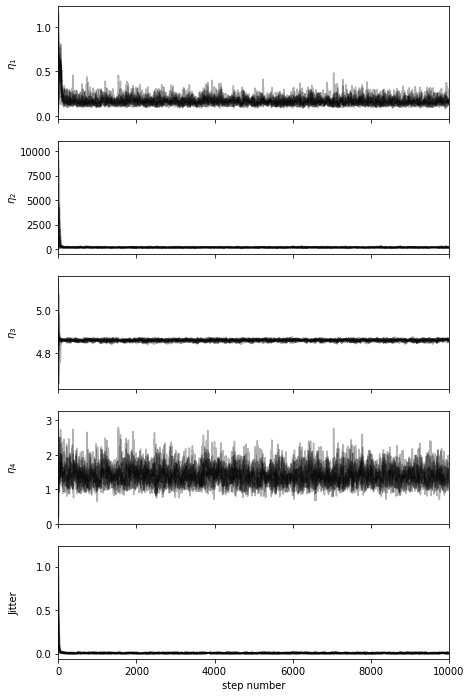

In [54]:
#chains plot
fig, axes = plt.subplots(5, figsize=(7, 12), sharex=True)
samples = sampler.get_chain()
labels = ["$\eta_1$", "$\eta_2$", "$\eta_3$", "$\eta_4$", "Jitter"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number");
plt.show()

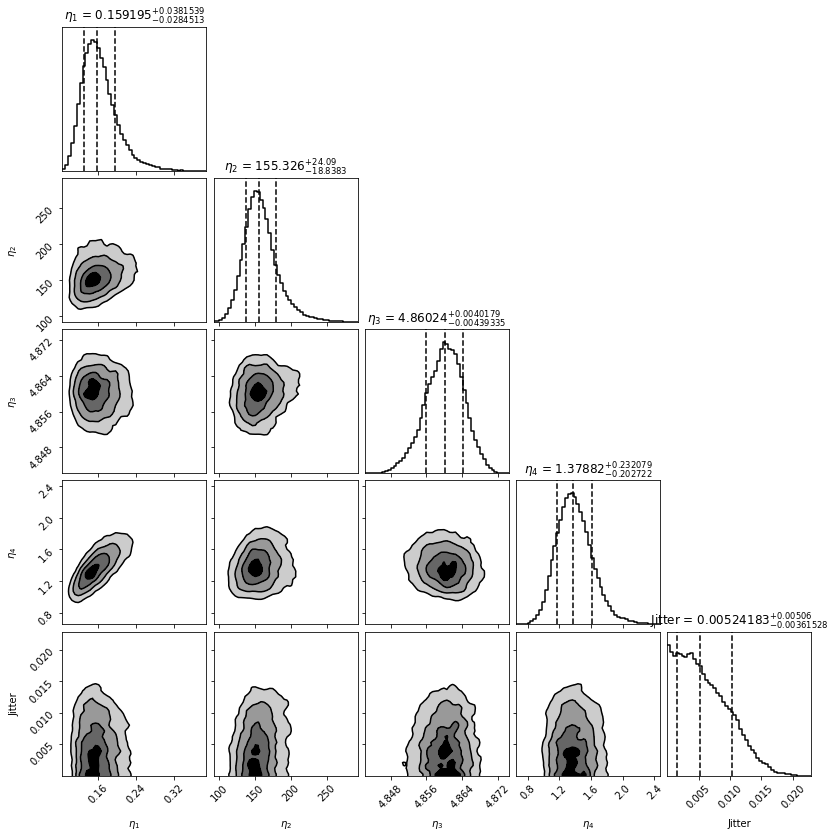

In [55]:
#corner plot
flat_samples = sampler.get_chain(discard=500, thin=15, flat=True)
fig = corner.corner(flat_samples,labels=labels, color="k", bins = 50,
                    quantiles=[0.16, 0.5, 0.84], smooth=True, smooth1d=True, 
                    show_titles=True, plot_density=True, plot_contours=True,
                    fill_contours=True, plot_datapoints=False, title_fmt='g')
plt.show()

#### On retrouve l'exact même résultat que Donati et al. (Submitted) ! 

In [62]:
def Display(HyperParam, tplot):
    n1,n2,n3,n4, j = HyperParam
    
    kernel = kernels.QuasiPeriodic(n1,n2,n3,n4) + kernels.WhiteNoise(j)
    mean = means.Constant(np.mean(B))
    gpOBJ = process.GP(kernel,mean,times_B,B,yerr = dB)
    
    y_mean, y_std, time = gpOBJ.prediction(kernel,mean,tplot)
    return y_mean

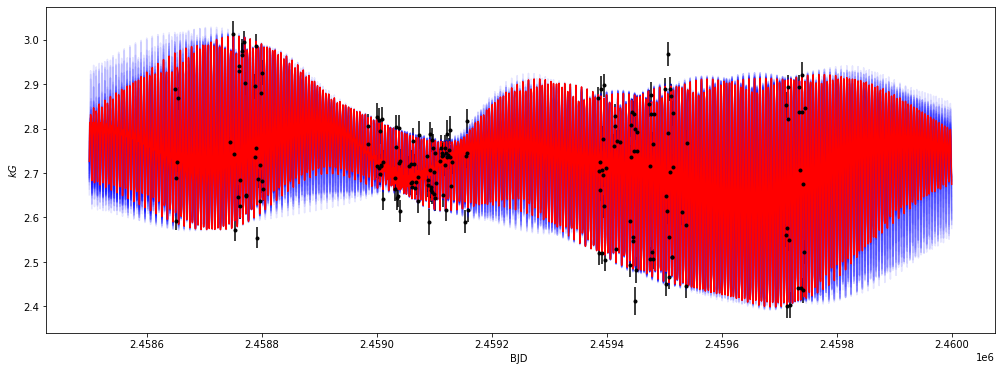

In [60]:
plt.figure(figsize=(17, 6))


for s in range(25):
    plt.plot(tplot, Display(flat_samples[s,:], tplot), 'b', alpha=0.1)
Hfit = np.median(sampler.flatchain, axis=0)
GPb = Display(Hfit, tplot)
plt.plot(tplot, GPb, 'r')
plt.errorbar(times_B, B, yerr=dB, fmt='k.')
plt.xlabel('BJD ')
plt.ylabel('$kG$')
plt.show()

100%|██████████| 15/15 [00:02<00:00,  6.11it/s]


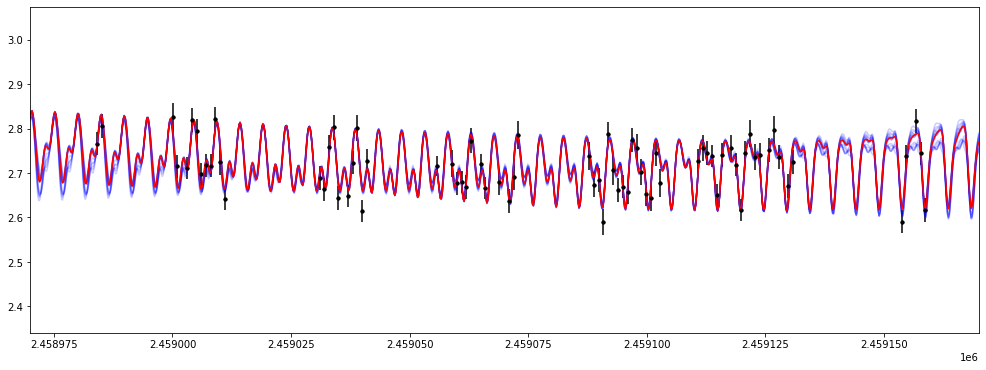

In [65]:
plt.figure(figsize=(17, 6))

tplot2 = np.linspace(-30+ 2459000,170+ 2459000, 1000)
 
for s in tqdm(range(15)):
    plt.plot(tplot2, Display(flat_samples[s,:], tplot2), 'b', alpha=0.2)
Hfit = np.median(sampler.flatchain, axis=0)
plt.plot(tplot2, Display(Hfit, tplot2), 'r')
plt.errorbar(times_B, B, yerr=dB, fmt='k.')
plt.xlim([-30 + 2459000,170 + 2459000])
plt.show()

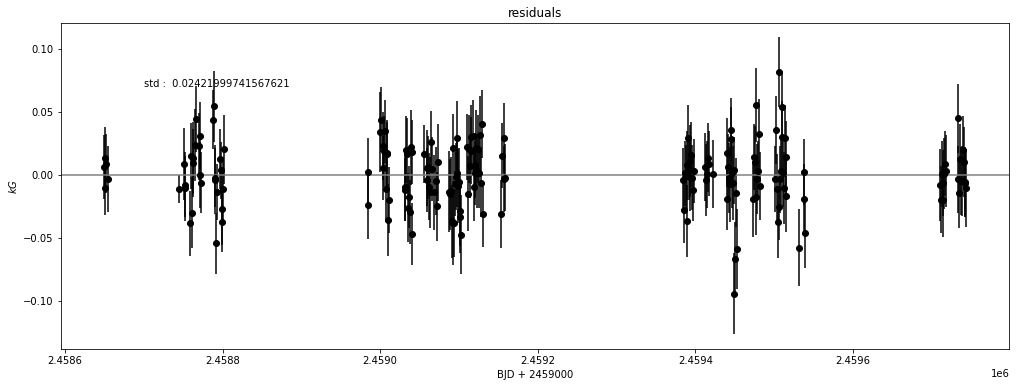

In [66]:
y_sample = Display(Hfit, times_B)

residuals = B - y_sample
plt.figure(figsize=(17, 6))
plt.errorbar(times_B, residuals, yerr=dB, fmt='ok')
plt.annotate( "std :  " + str(np.std(residuals)), (+ 2459000 -300, 0.07) )
plt.axhline(y=0, c='grey')
plt.title('residuals')
plt.xlabel('BJD + 2459000')
plt.ylabel('$kG$')
plt.show()

### Correlation Coef Between W1 and B

In [100]:
def reshapetocorr(t1, d1, t2, d2, dd1 = None, dd2 = None, verbose = False):

    i, j = 0, 0
    D1 = np.copy(d1)
    T1 = np.copy(t1)
    D2 = np.copy(d2)
    T2 = np.copy(t2)
    if dd1 is not None:
        dD1 = np.copy(dd1)
    if dd2 is not None:
        dD2 = np.copy(dd2)
    while i < len(T1) and j < len(T2):
        diff = T1[i] - T2[j]
        if np.abs(diff) < 0.5:
            i += 1
            j += 1
        elif diff > 0.5:
            if verbose :
                print('L', T1[i], 'R', T2[j])
                print('point remove R')
            T2 = np.delete(T2, j)
            D2 = np.delete(D2, j)
            if dd2 is not None:
                dD2 = np.delete(dD2, j)
        elif diff < -0.5:
            if verbose :
                print('L', T1[i], 'R', T2[j])
                print('point remove L')
            T1 = np.delete(T1, i)
            D1 = np.delete(D1, i)
            if dd1 is not None:
                dD1 = np.delete(dD1, j)
        
    T1 = T1[:i]
    D1 = D1[:i]
    T2 = T2[:j]
    D2 = D2[:j]
    if dd1 is not None:
        dD1 = dD1[:j]
    if dd2 is not None:
        dD2 = dD2[:j]
    if dd1 is None:
        dD1 = None
    if dd2 is None:
        dD2 = None
    
    return(T1, D1, T2, D2, dD1, dD2)

In [81]:
twcorr, wcorr, tbcorr, bcorr, __, dbcorr = reshapetocorr(times, eigen2vectors[0], times_B, B, dd2 = dB)

L 2458654.0385279832 R 2458652.0119888
point remove R
L 2458978.0914811227 R 2458984.1201482
point remove L
L 2458979.0764584425 R 2458984.1201482
point remove L
L 2458980.09878312 R 2458984.1201482
point remove L
L 2458982.1069160462 R 2458984.1201482
point remove L
L 2458983.0948567404 R 2458984.1201482
point remove L
L 2459004.070251993 R 2459003.0657407
point remove R
L 2459070.9356470183 R 2459068.9014223
point remove R
L 2459388.0576466247 R 2459387.0534251
point remove R
L 2459504.775162982 R 2459503.7918633
point remove R


In [82]:
print(twcorr - tbcorr)

[-1.62641518e-05 -6.37955964e-07 -2.18534842e-06 -9.91672277e-06
 -3.01459804e-05  3.72249633e-05  2.31489539e-05 -6.70570880e-05
  1.40783377e-05 -9.35122371e-05  5.81649132e-04 -4.36706468e-05
  8.19917768e-05  1.52410939e-05  8.87410715e-06 -5.38970344e-05
  5.72865829e-05 -1.21421181e-05  1.74997374e-04  2.58564018e-04
  1.15652103e-04 -1.44144055e-04  9.28668305e-06  5.20129688e-05
 -5.71054406e-05  3.67905013e-05 -1.12599228e-04 -5.46304509e-05
  3.10903415e-05 -1.18381809e-04  1.00472942e-04 -3.52747738e-05
 -3.92240472e-05 -6.75814226e-06  7.04638660e-06 -5.16069122e-05
  5.40390611e-05  1.11912377e-05  7.28294253e-06 -8.42991285e-05
  7.29202293e-05  1.36968074e-03 -6.95735216e-05 -3.81655991e-06
 -5.95953315e-06 -2.48602591e-05 -5.97150065e-05 -3.17236409e-05
  3.94643284e-05 -4.63332981e-05 -1.21722929e-04  7.02161342e-05
  1.05146319e-06  3.44053842e-05  2.82581896e-05  6.19390048e-05
  9.62861814e-05  1.70399435e-05  1.74106099e-05  1.46385282e-05
  1.75661407e-05 -2.77481

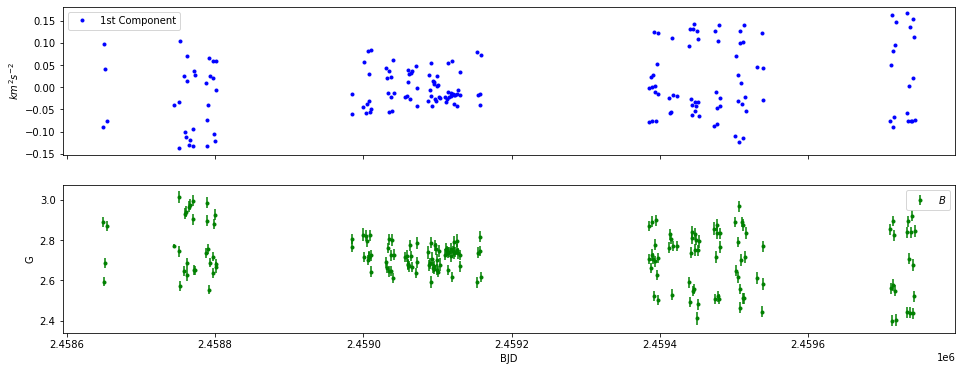

In [84]:
plt.figure(figsize=(16, 6))
ax1 = plt.subplot(211)
plt.plot(twcorr, wcorr, 'b.', label='1st Component')
plt.ylabel('$km^2 s^{-2}$')
plt.legend()
plt.tick_params('x', labelbottom=False)


# share x and y
ax3 = plt.subplot(212, sharex=ax1)
plt.errorbar(tbcorr, bcorr, yerr=dbcorr, fmt='.g', label='$B$')
plt.xlabel('BJD')
plt.ylabel('G')
plt.legend()
plt.show()

In [86]:
pearsonr(bcorr, wcorr)

(-0.9602252378428018, 1.1570364985953769e-101)

R = 0.97 Donati et al (2023, submitted)

### Correlation between GPs of W1 and B

In [87]:
pearsonr(GPca, GPb)

(-0.9418927534333215, 0.0)

## Comparison /w RVs 

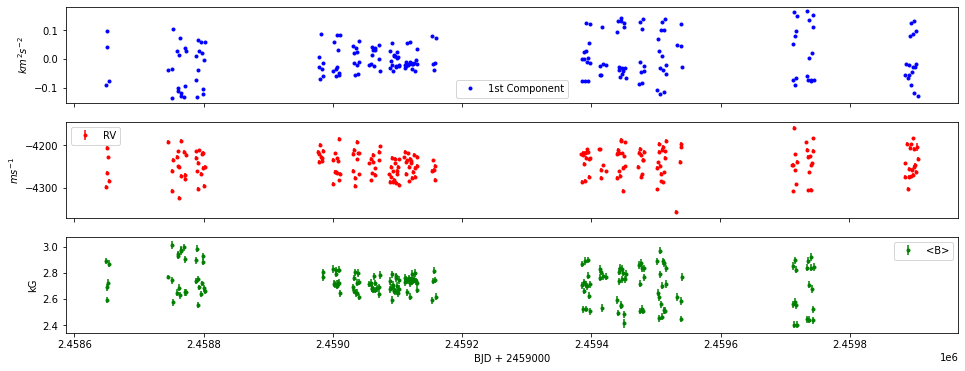

In [122]:
times_RV, RV, dRV = np.loadtxt('/media/paul/One Touch2/SPIRou_Data/AU_MIC/lbl2_AUMIC_AUMIC.rdb',
                   usecols=(0,1,2),skiprows=2, dtype=str, unpack=True)

times_RV = np.array(times_RV.astype(float)) + 2.4e6
RV = np.array(RV.astype(float))
dRV = np.array(dRV.astype(float))

# Remove an obsvious outlier
index_outlier = np.argmax(dRV)
times_RV = np.delete(times_RV, index_outlier)
RV = np.delete(RV, index_outlier)
dRV = np.delete(dRV, index_outlier)


plt.figure(figsize=(16, 6))
ax1 = plt.subplot(311)
plt.plot(times_pca, eigen2vectors[0], 'b.', label='1st Component')
plt.ylabel('$km^2 s^{-2}$')
plt.legend()
plt.tick_params('x', labelbottom=False)

ax2 = plt.subplot(312)
plt.errorbar(times_RV, RV, yerr = dRV, fmt='r.', label='RV')
plt.ylabel('$m s^{-1}$')
plt.legend()
plt.tick_params('x', labelbottom=False)

# share x and y
ax3 = plt.subplot(313, sharex=ax1)
plt.errorbar(times_B, B, yerr=dB, fmt='.g', label='<B>')
plt.xlabel('BJD + 2459000')
plt.ylabel('kG')
plt.legend()
plt.show()

Peak frequency = 
4.872250163692226


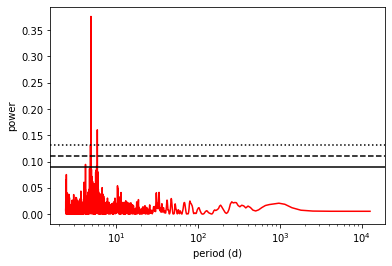

In [123]:
frequency, power = LombScargle(times_RV, RV, dRV).autopower()
plt.figure(2)
plt.plot(1/frequency, power, 'r')
plt.xlabel("period (d)")
plt.ylabel("power")
plt.xscale('log')


peak_freq = 1 / frequency[np.argmax(power)]
print('Peak frequency = ')
print(peak_freq)

ls = LombScargle(times_RV, RV, dRV)

fap = ls.false_alarm_level(0.1)
plt.axhline(fap, linestyle='-', color='k')

fap = ls.false_alarm_level(0.01)
plt.axhline(fap, linestyle='--', color='k')

fap = ls.false_alarm_level(0.001)
plt.axhline(fap, linestyle=':', color='k')

plt.show()

### Simple Correlations 

In [124]:
print('RV X B :')
trvcorrb, rvcorrb, tbcorrrv, bcorrrv, drvcorrb, dbcorrrv = reshapetocorr(times_RV, RV, times_B, B, dd1 = dRV,dd2 = dB)
print(pearsonr(bcorrrv, rvcorrb))

print('RV X W1 :')
trvcorrw, rvcorrw, twcorrrv, wcorrrv, drvcorrw, dwcorrrv = reshapetocorr(times_RV, RV, times, eigen2vectors[0], dd1 = dRV)
print(pearsonr(wcorrrv, rvcorrw))

RV X B :
(0.11794960184050017, 0.10885170766180405)
RV X W1 :
(-0.09108634902802165, 0.1950877674774899)


RV X B -> R = 0.12 Donati et al. (2023, submitted)

### first derivative correlations 

In [125]:
Bp = np.gradient(B, times_B)
Wp = np.gradient(eigen2vectors[0], times)

In [126]:
print('RV X dB/dt :')
trvcorrbp, rvcorrbp, tbpcorrrv, bpcorrrv, drvcorrbp, __ = reshapetocorr(times_RV, RV, times_B, Bp, dd1 = dRV)
print(pearsonr(bpcorrrv, rvcorrbp))

print('RV X dW1/dt :')
trvcorrwp, rvcorrwp, twpcorrrv, wpcorrrv, drvcorrwp, __ = reshapetocorr(times_RV, RV, times, Wp, dd1 = dRV)
print(pearsonr(wcorrrv, rvcorrw))

RV X dB/dt :
(0.6863724603408872, 3.017349171587831e-27)
RV X dW1/dt :
(-0.09108634902802165, 0.1950877674774899)


RV X B' -> R = 0.80 Donati et al. (2023, submitted)

### RV GP 

Note : a future work will be to add the known planets in the RV signal

In [127]:
print(2*(np.max(RV)- np.min(RV)))
print(np.std(RV))
print(10*(np.max(times_RV)-np.min(times_RV)))

393.82589078008095
31.842086602417222
12565.53317216225


In [128]:
#Priors
n_eta1 = ModifiedLogUniform(30, 400)
n_eta2 = stats.loguniform(1, 11000)
n_eta3 = stats.norm(loc=4.87, scale=0.03)
n_eta4 = stats.loguniform(0.1, 5)
jitter = ModifiedLogUniform(0.12, 3.2)

def priors():
    return np.array([n_eta1.rvs(),n_eta2.rvs(), n_eta3.rvs(), n_eta4.rvs(), jitter.rvs()])

def logPosterior(HyperParam):
    n1,n2,n3,n4, j = HyperParam
    
    logprior = n_eta1.logpdf(n1)
    logprior += n_eta2.logpdf(n2)
    logprior += n_eta3.logpdf(n3)
    logprior += n_eta4.logpdf(n4)
    logprior += jitter.logpdf(j)
    
    kernel = kernels.QuasiPeriodic(n1,n2,n3,n4) + kernels.WhiteNoise(j)
    mean = means.Constant(np.mean(RV))
    gpOBJ = process.GP(kernel,mean,times_RV,RV, yerr = dRV)
    
    logposterior = gpOBJ.log_likelihood() + logprior
    return logposterior



In [129]:
ndim = priors().size 
nwalkers = 2*ndim

sampler = emcee.EnsembleSampler(nwalkers, ndim, logPosterior)
p0=[priors() for i in range(nwalkers)]
sampler.run_mcmc(p0, 10000, progress=True)

100%|██████████| 10000/10000 [09:29<00:00, 17.55it/s]


State([[3.26669692e+01 7.26207131e+00 4.86434414e+00 6.34205985e-01
  1.58154433e+00]
 [2.88650610e+01 7.41068649e+00 4.88904033e+00 3.38937088e-01
  1.15307295e-01]
 [3.34163852e+01 6.22312413e+00 4.85376536e+00 6.17512656e-01
  1.01650493e+00]
 [3.15197001e+01 6.90860220e+00 4.88498506e+00 5.07538167e-01
  2.08863514e-03]
 [3.22280267e+01 6.30270755e+00 4.90518023e+00 5.06263356e-01
  9.61269993e-03]
 [2.85607018e+01 6.66882251e+00 4.93101756e+00 5.99238732e-01
  2.89196198e+00]
 [3.15057265e+01 6.24462133e+00 4.88104312e+00 6.11557634e-01
  3.00681128e-01]
 [3.29544117e+01 6.24296585e+00 4.87414531e+00 6.67131027e-01
  9.99303456e-01]
 [3.09473666e+01 6.53671079e+00 4.90302657e+00 5.57691735e-01
  2.84370530e-01]
 [3.45204632e+01 7.27979994e+00 4.88632291e+00 6.64521113e-01
  2.80283485e-01]], log_prob=[-988.32722955 -989.83104293 -989.27227204 -985.69073423 -986.14408346
 -989.53815736 -986.22744346 -987.77106476 -986.30544275 -987.67887303], blobs=None, random_state=('MT19937', ar

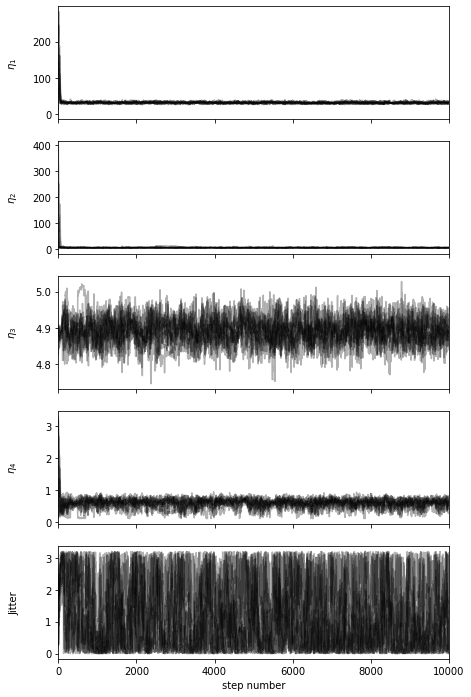

In [130]:
#chains plot
fig, axes = plt.subplots(5, figsize=(7, 12), sharex=True)
samples = sampler.get_chain()
labels = ["$\eta_1$", "$\eta_2$", "$\eta_3$", "$\eta_4$", "Jitter"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number");
plt.show()

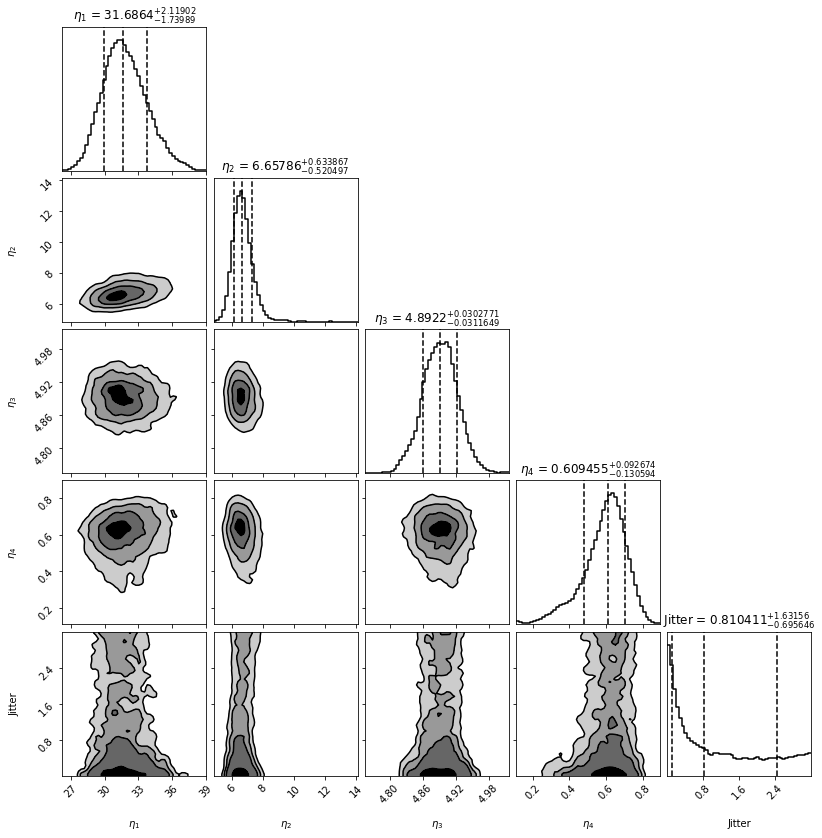

In [131]:
#corner plot
flat_samples = sampler.get_chain(discard=500, thin=15, flat=True)
fig = corner.corner(flat_samples,labels=labels, color="k", bins = 50,
                    quantiles=[0.16, 0.5, 0.84], smooth=True, smooth1d=True, 
                    show_titles=True, plot_density=True, plot_contours=True,
                    fill_contours=True, plot_datapoints=False, title_fmt='g')
plt.show()

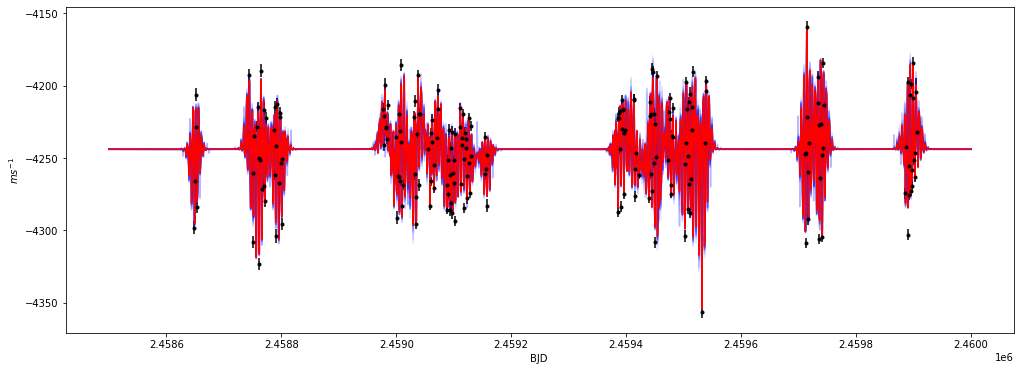

In [132]:
def Display(HyperParam, tplot):
    n1,n2,n3,n4, j = HyperParam
    
    kernel = kernels.QuasiPeriodic(n1,n2,n3,n4) + kernels.WhiteNoise(j)
    mean = means.Constant(np.mean(RV))
    gpOBJ = process.GP(kernel,mean,times_RV,RV,yerr = dRV)
    
    y_mean, y_std, time = gpOBJ.prediction(kernel,mean,tplot)
    return y_mean

plt.figure(figsize=(17, 6))


for s in range(25):
    plt.plot(tplot, Display(flat_samples[s,:], tplot), 'b', alpha=0.1)
Hfit = np.median(sampler.flatchain, axis=0)
GPrv = Display(Hfit, tplot)
plt.plot(tplot, GPrv, 'r')
plt.errorbar(times_RV, RV, yerr=dRV, fmt='k.')
plt.xlabel('BJD ')
plt.ylabel('$m s^{-1}$')
plt.show()

100%|██████████| 15/15 [00:08<00:00,  1.78it/s]


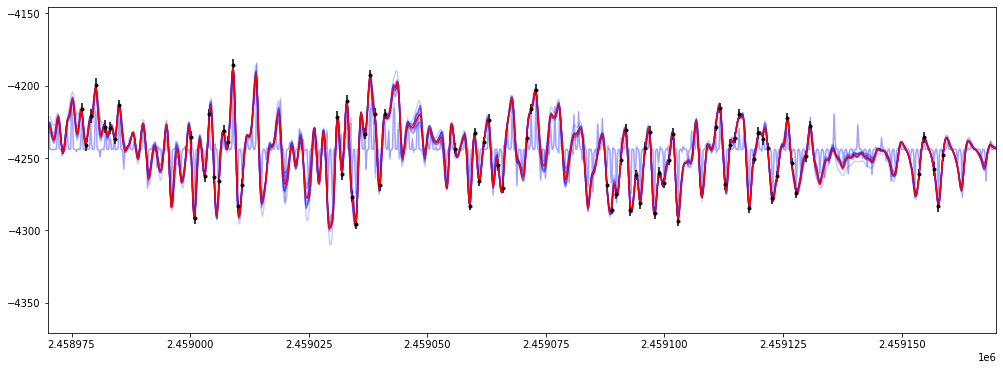

In [133]:
plt.figure(figsize=(17, 6))

tplot2 = np.linspace(-30+ 2459000,170+ 2459000, 1000)
 
for s in tqdm(range(15)):
    plt.plot(tplot2, Display(flat_samples[s,:], tplot2), 'b', alpha=0.2)
Hfit = np.median(sampler.flatchain, axis=0)
plt.plot(tplot2, Display(Hfit, tplot2), 'r')
plt.errorbar(times_RV, RV, yerr=dRV, fmt='k.')
plt.xlim([-30 + 2459000,170 + 2459000])
plt.show()

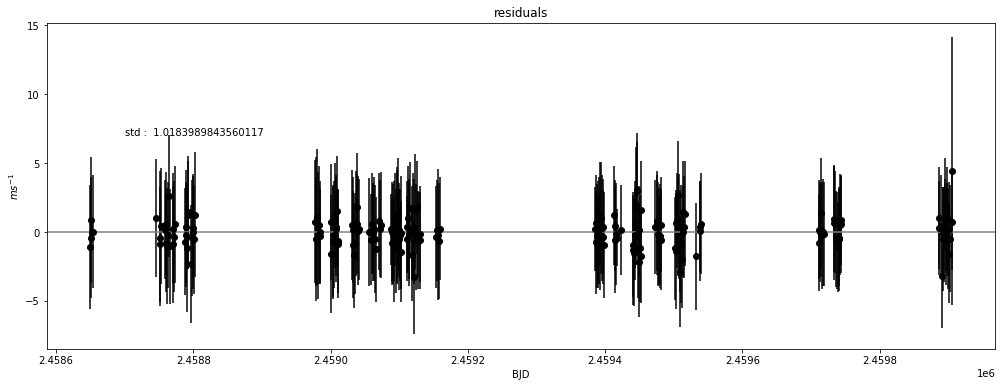

In [135]:
y_sample = Display(Hfit, times_RV)

residuals = RV - y_sample
plt.figure(figsize=(17, 6))
plt.errorbar(times_RV, residuals, yerr=dRV, fmt='ok')
plt.annotate( "std :  " + str(np.std(residuals)), (+ 2459000 -300, 7) )
plt.axhline(y=0, c='grey')
plt.title('residuals')
plt.xlabel('BJD')
plt.ylabel('$m s^{-1}$')
plt.show()

###  Correlations  Between GPs

In [136]:
print('RV X B :')
print(pearsonr(GPb, GPrv))

print('RV X W1 :')
print(pearsonr(GPrv, GPca))

RV X B :
(0.04647514800247603, 0.03768584272630308)
RV X W1 :
(-0.02421411497082872, 0.27908822840085235)


### first derivative correlations 

In [138]:
GP_Bp = np.gradient(GPb, tplot)
GP_Wp = np.gradient(GPca, tplot)

In [139]:
print('RV X dB/dt :')
print(pearsonr(GP_Bp, GPrv))

print('RV X dW1/dt :')
print(pearsonr(GPrv, GP_Wp))

RV X dB/dt :
(0.432565482168891, 5.4300165527181234e-92)
RV X dW1/dt :
(-0.42990620086025483, 9.1174754292712e-91)
